# DHFR analysis
A notebook to visually analyze the fingerprints and understand the degrees of their interpretability.


## Libraries import

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import rasterio
import cv2
from pathlib import Path
import os
import warnings
warnings.filterwarnings('ignore')

## Helpers functions

In [2]:
import scipy
from scipy.fft import fft2, fftshift
from scipy import ndimage

#===================================================================
# Get PSD 1D (total radial power spectrum)
#===================================================================
def GetAAPSD(psd2D, minBin=0, maxBin=0):
    """
    Compute the total power of the spectra along a radius of frequencies
    """
    h  = psd2D.shape[0]
    w  = psd2D.shape[1]
    wc = w//2
    hc = h//2

    # create an array of integer radial distances from the center
    Y, X = np.ogrid[0:h, 0:w]
    r    = np.hypot(X - wc, Y - hc).astype(np.int)

    # SUM all psd2D pixels with label 'r' for 0<=r<=wc
    # NOTE: this will miss power contributions in 'corners' r>wc
    maxBin = maxBin if maxBin else wc
    psd1D = ndimage.sum(psd2D, r, index=np.arange(minBin, maxBin))

    return psd1D
#===================================================================


#=============================================================================
# Get PSD 1D (total power spectrum by angular bin)
#=============================================================================
def GetRPSD(psd2D: np.array, dTheta: float, rMin: np.array=None, rMax: np.array=None):
    """
    In this case, we compute either the sum or mean of the power spectrum in specific angular sections.
    """
    h  = psd2D.shape[0]
    w  = psd2D.shape[1]
    wc = w//2
    hc = h//2
    
    # note that displaying PSD as image inverts Y axis
    # create an array of integer angular slices of dTheta
    Y, X  = np.ogrid[0:h, 0:w]
    theta = np.rad2deg(np.arctan2(-(Y-hc), (X-wc)))
    theta = np.mod(theta + dTheta/2 + 360, 360)
    theta = dTheta * (theta//dTheta)
    theta = theta.astype(np.int)
    
    # mask below rMin and above rMax by setting to -100
    if rMin is None:
        rMin = np.hypot(X - hc, Y - wc).astype(np.int)  # exclude only DC component
    if rMax is None:
        rMax = np.hypot(X - 1, Y - 1).astype(np.int)
    R     = np.hypot(-(Y-hc), (X-wc))
    mask  = np.logical_and(R > rMin, R < rMax)
    theta = theta + 100
    theta = np.multiply(mask, theta)
    theta = theta - 100
    
    # SUM all psd2D pixels with label 'theta' for 0<=theta❤60 between rMin and rMax
    angF  = np.arange(0, 360, int(dTheta))
    psd1D = ndimage.sum(psd2D, theta, index=angF)
    
    # normalize each sector to the total sector power
    pwrTotal = np.sum(psd1D)
    psd1D    = psd1D/pwrTotal
    
    return angF, psd1D
#=============================================================================

## Load test results

In [3]:
img_dir = '../data/test_samples'
test_results = '../test_results/asae/all_ops_result_df.pkl'
df = pd.read_pickle(test_results)
df

filenames  \
Operation              Img_idx                                                
AdditiveLaplacianNoise 0        AdditiveLaplacianNoise/img_14_size_192.tiff   
                       1        AdditiveLaplacianNoise/img_18_size_192.tiff   
                       2        AdditiveLaplacianNoise/img_18_size_256.tiff   
                       3        AdditiveLaplacianNoise/img_22_size_192.tiff   
                       4        AdditiveLaplacianNoise/img_26_size_128.tiff   
...                                                                     ...   
NoEditing              495                   NoEditing/img_35_size_256.tiff   
                       496                   NoEditing/img_49_size_192.tiff   
                       497                   NoEditing/img_14_size_160.tiff   
                       498                   NoEditing/img_55_size_256.tiff   
                       499                   NoEditing/img_78_size_128.tiff   

                                                                     mask_paths  \
Operation              Img_idx                                                    
AdditiveLaplacianNoise 0        AdditiveLaplacianNoise/mask_img_14_size_192.png   
                       1        AdditiveLaplacianNoise/mask_img_18_size_192.png   
                       2        AdditiveLaplacianNoise/mask_img_18_size_256.png   
                       3        AdditiveLaplacianNoise/mask_img_22_size_192.png   
                       4        AdditiveLaplacianNoise/mask_img_26_size_128.png   
...                                                                         ...   
NoEditing              495                   NoEditing/mask_img_35_size_256.png   
                       496                   NoEditing/mask_img_49_size_192.png   
                       497                   NoEditing/mask_img_14_size_160.png   
                       498                   NoEditing/mask_img_55_size_256.png   
                       499                   NoEditing/mask_img_78_size_128.png   

                                splice_size  \
Operation              Img_idx                
AdditiveLaplacianNoise 0                192   
                       1                192   
                       2                256   
                       3                192   
                       4                128   
...                                     ...   
NoEditing              495              256   
                       496              192   
                       497              160   
                       498              256   
                       499              128   

                                                                          fp_path  
Operation              Img_idx                                                     
AdditiveLaplacianNoise 0        test_results/asae/AdditiveLaplacianNoise/finge...  
                       1        test_results/asae/AdditiveLaplacianNoise/finge...  
                       2        test_results/asae/AdditiveLaplacianNoise/finge...  
                       3        test_results/asae/AdditiveLaplacianNoise/finge...  
                       4        test_results/asae/AdditiveLaplacianNoise/finge...  
...                                                                           ...  
NoEditing              495      test_results/asae/NoEditing/fingerprints/fp_im...  
                       496      test_results/asae/NoEditing/fingerprints/fp_im...  
                       497      test_results/asae/NoEditing/fingerprints/fp_im...  
                       498      test_results/asae/NoEditing/fingerprints/fp_im...  
                       499      test_results/asae/NoEditing/fingerprints/fp_im...  

[3500 rows x 4 columns]

## Average spectrum
Let's try to compute the average spectrum for a certain number of images from each attack, divided into the two families of attacks.  
For each spliced area size in the dataset and editing operation, we take 25 images.

In [4]:
from tqdm.notebook import tqdm
# --- Let's cycle over them
spec_mean = dict()
num_imgs = 25
for sa in tqdm(df['splice_size'].unique(), desc='Doing different spliced areas'):
    spec_mean[sa] = dict()
    for op in df.index.get_level_values(0).unique():
        sel_df = df.loc[op]
        sel_df = sel_df.loc[sel_df['splice_size']==sa]
        sel_df = sel_df.iloc[:num_imgs]
        spec_mean[sa][op] = 0
        for i, row in sel_df.iterrows():
            img_path, mask_path = row['filenames'], row['mask_paths']

            # Load the sample and mask
            with rasterio.open(os.path.join(img_dir, img_path)) as src:
                img = src.read()
            mask = cv2.imread(os.path.join(img_dir, mask_path), cv2.IMREAD_UNCHANGED)

            # Load the spliced area
            sp_area = img[0][mask.astype(np.bool)].reshape([sa, sa])

            # Compute the spectrum
            fft_sp = np.fft.fft2(sp_area, norm='ortho')
            out_shift = np.abs(np.fft.fftshift(fft_sp))

            # Add the spectrum and average
            spec_mean[sa][op] += out_shift
        
        # Compute the mean
        spec_mean[sa][op] /= len(sel_df)

Doing different spliced areas:   0%|          | 0/5 [00:00<?, ?it/s]

/nas/home/ecannas/miniconda3/envs/dhfr_int/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/tmp/ipykernel_578527/3618283213.py:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sp_area = img[0][mask.astype(np.bool)].reshape([sa, sa])


### Let's compare the average spectrums by family of editing
We consider specifically `No editing`, `Blur-based`, and `Noise-based`.  

In [12]:
nb_ops = ['AdditiveWhiteGaussianNoise', 'AdditiveLaplacianNoise', 'SpeckleNoise']
ib_ops = ['AverageBlur', 'MedianBlur', 'RotationResize']
mean_specs = dict()
for sa in df['splice_size'].unique():
    ops = df.index.get_level_values(0).unique()
    op_specs = {'No editing': 0, 'Blur-based': 0, 'Noise-based': 0}
    for op in ops:
        if op in nb_ops:
            op_specs['Noise-based'] += spec_mean[sa][op]/len(nb_ops)
        elif op in ib_ops:
            op_specs['Blur-based'] += spec_mean[sa][op]/len(ib_ops)
        else:
            op_specs['No editing'] = spec_mean[sa][op]
    mean_specs[sa] = op_specs

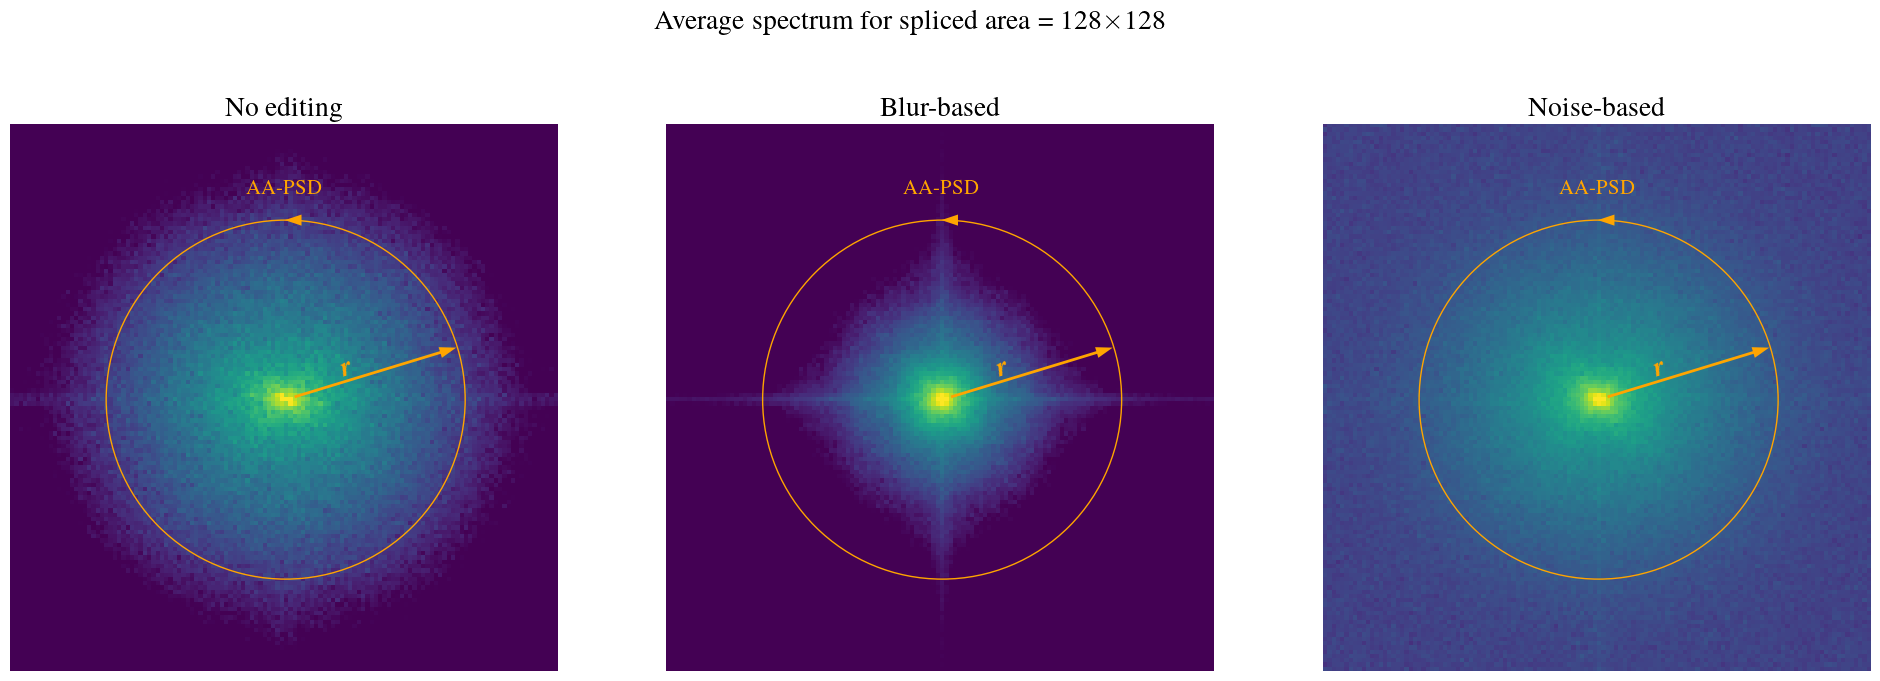

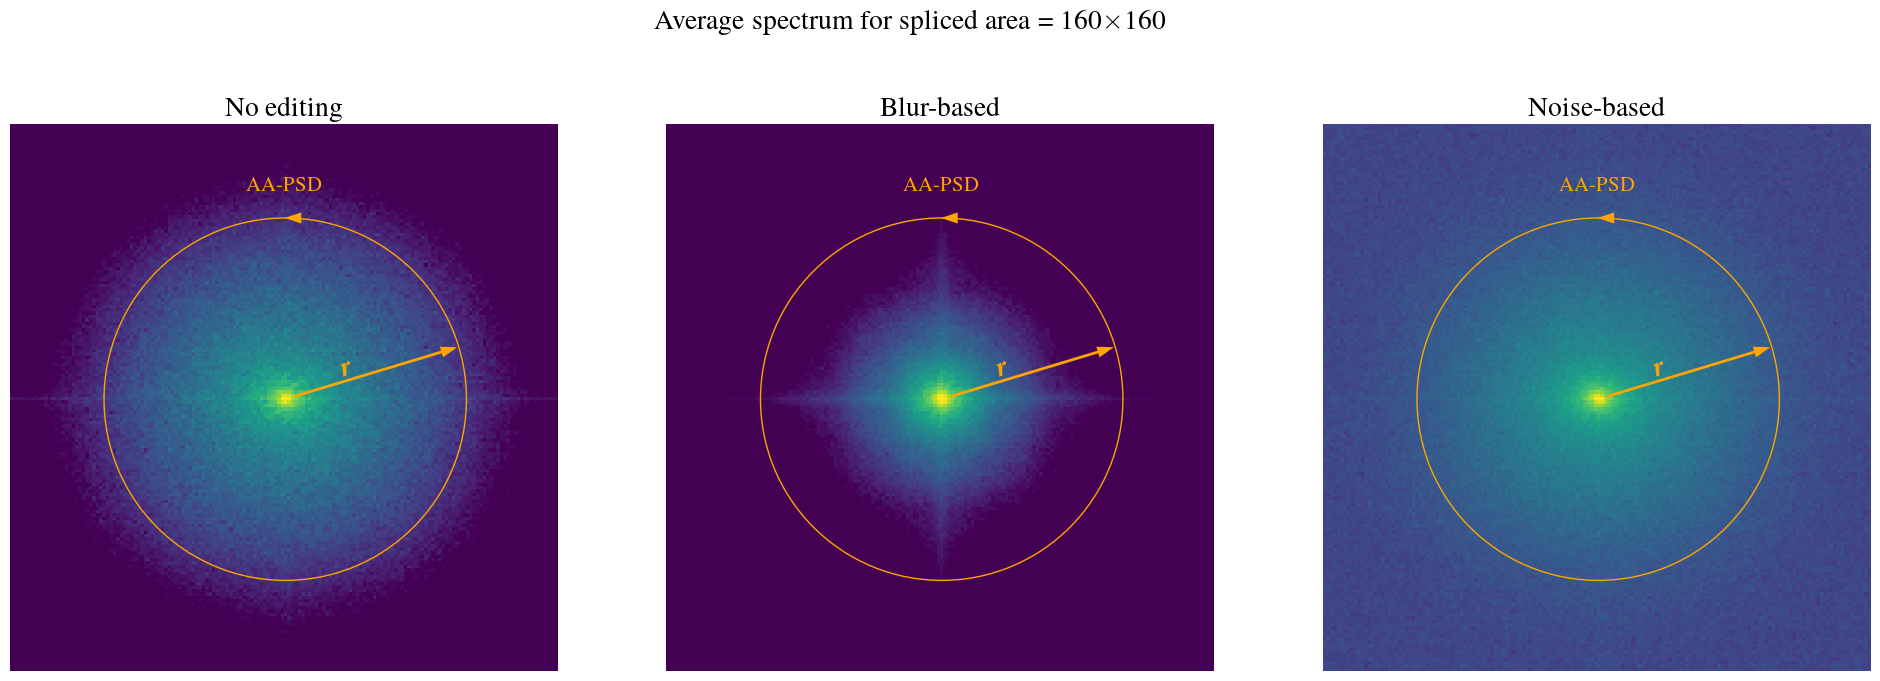

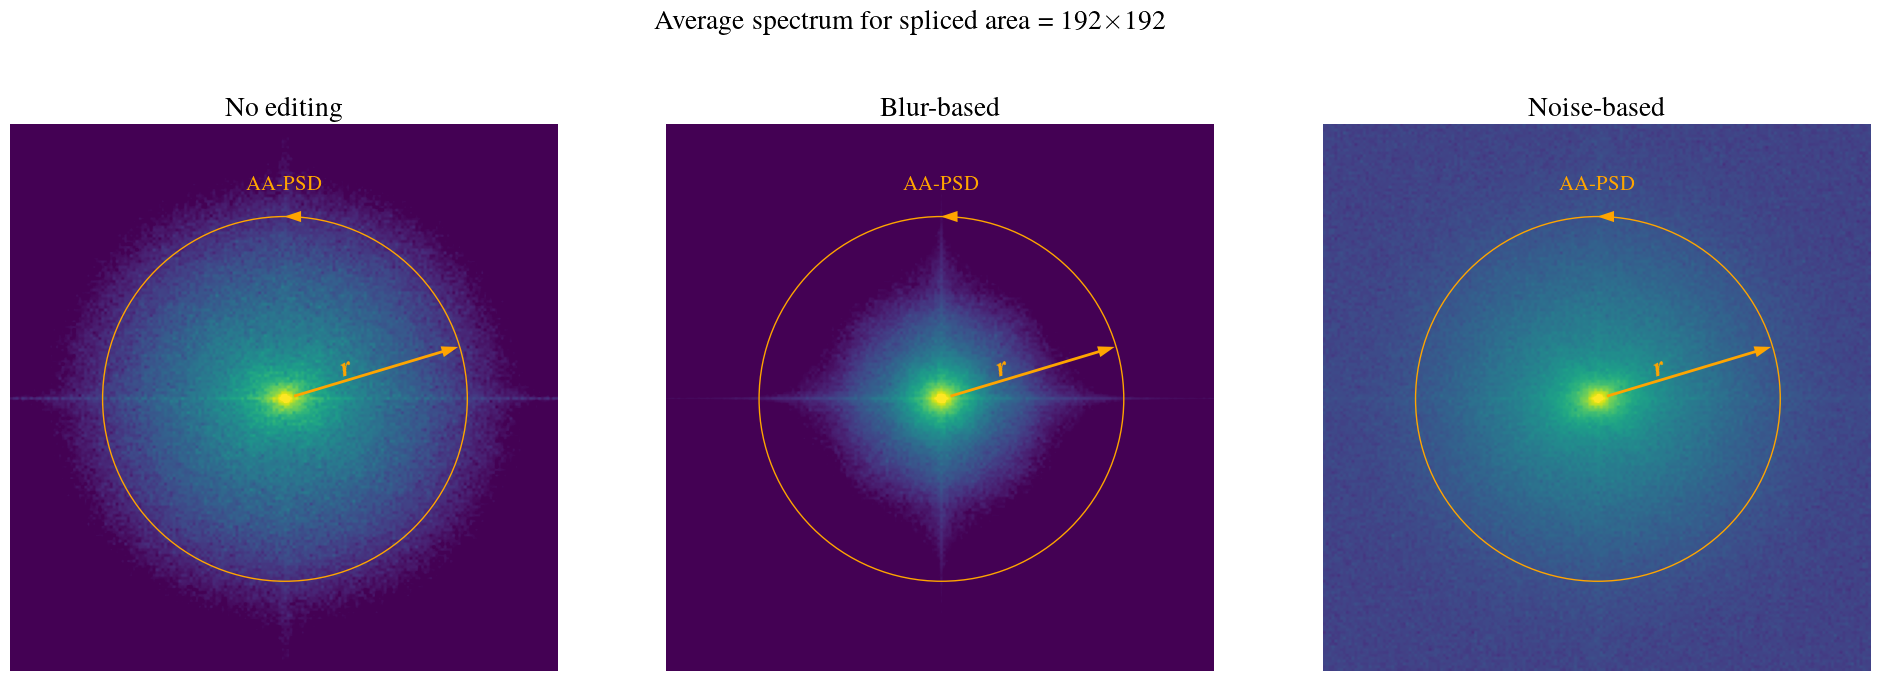

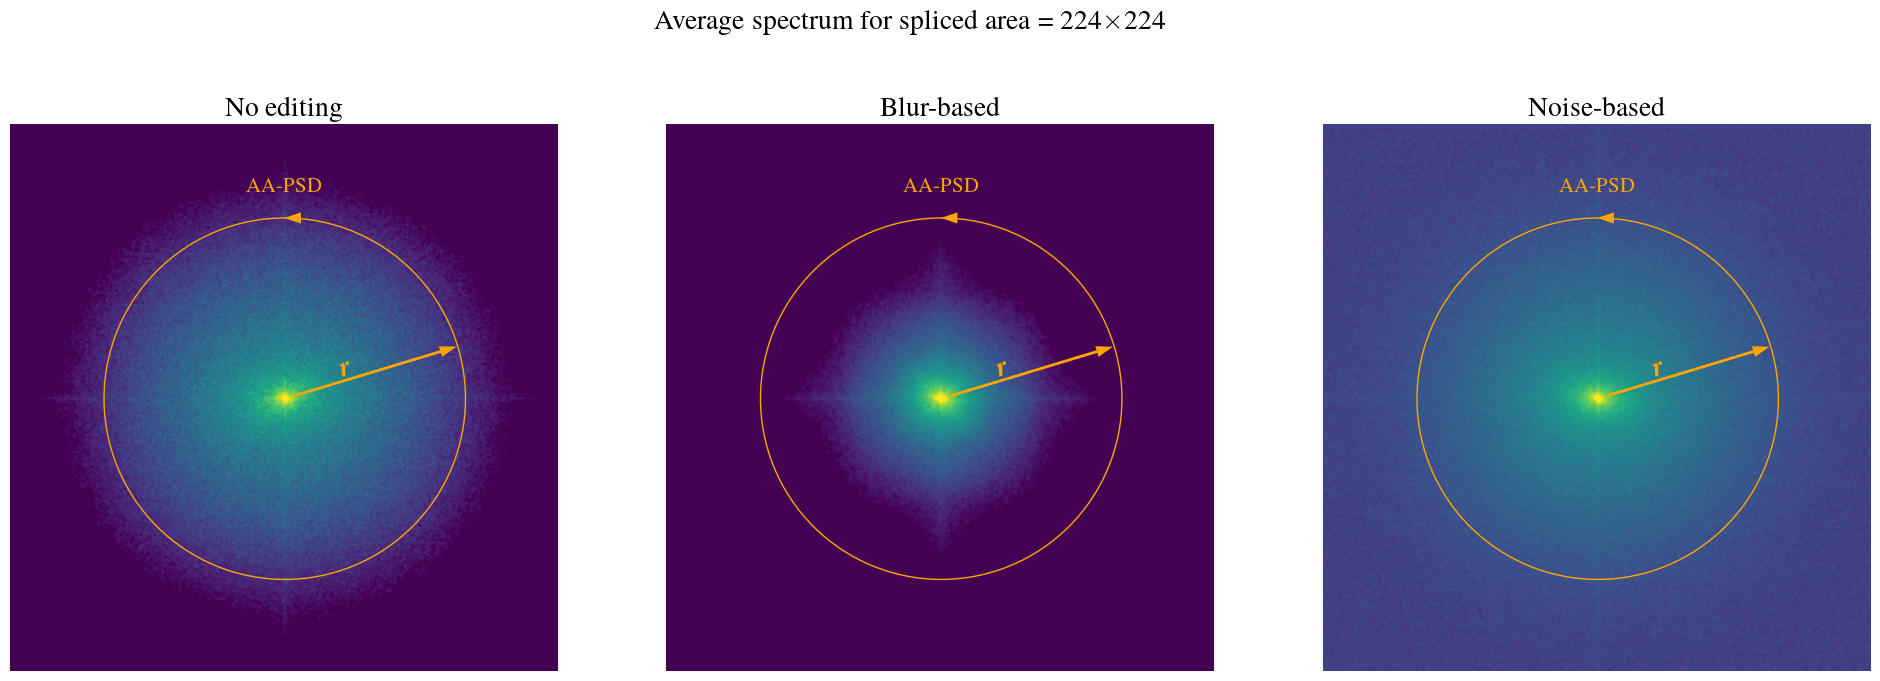

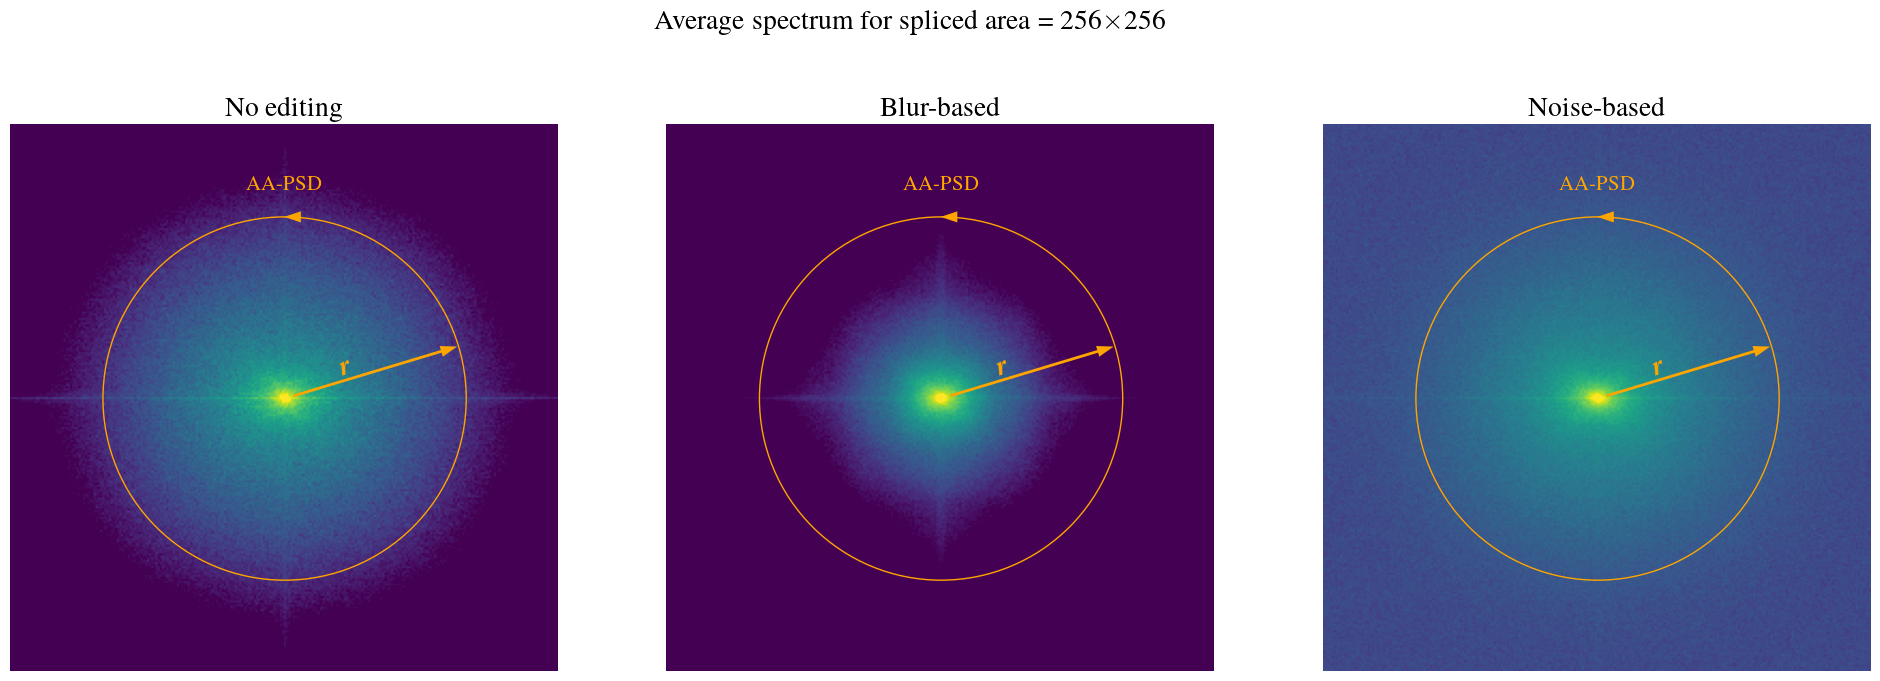

In [19]:
from matplotlib import rc
rc('font',**{'family':'Times'})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
from matplotlib.patches import FancyArrowPatch

fsize = 20
for sa in sorted(df['splice_size'].unique()):
    # Create the figure
    ops = ['No editing', 'Blur-based', 'Noise-based']
    # Cycle over the operations
    images = []
    # Create the figure
    fig, ax = plt.subplots(1, 3, figsize=(8*len(ops), 8))
    for idx, op in enumerate(ops):
        # Create the figure
        
        # Display the spectrum
        ax[idx].imshow(np.log(mean_specs[sa][op] + 1), clim=[2, 6])
        
        # Define the center and radius of the circle
        center = (sa//2, sa//2)
        radius = sa//3

        # Draw the circle
        circle = plt.Circle(center, radius, edgecolor='orange', facecolor='none')
        ax[idx].add_patch(circle)

        # Define the arrow
        arrow_start = center
        arrow_end = (center[0] + radius, center[1]-center[1]/5)

        # Draw the arrow
        ax[idx].annotate('', xy=arrow_end, xytext=arrow_start,
                    arrowprops=dict(facecolor='orange', edgecolor='none', width=2, headwidth=8, shrink=0.05))

        # Add text along the arrow
        #text_position = (center[0] + radius / 2, center[1]+center[1]/6)
        text_position = (center[0] + radius/3, center[1]-center[1]/16)
        ax[idx].text(text_position[0], text_position[1], r'\textbf{\textit{r}}', color='orange', ha='center', va='bottom', 
                rotation=21, fontsize=20)

        # Define the head of the arrow for the AA-PSD text
        ax[idx].annotate('', xy=(center[0]-0.2, center[1]-radius), xytext=(center[0], center[1]-radius),
                    arrowprops=dict(facecolor='orange', edgecolor='none', width=2, headwidth=8, shrink=0.05))
        # Add text along the circle
        #text_position = (center[0] + radius / 2, center[1]+center[1]/6)
        text_position = (center[0]-0.5, center[1]-radius-radius/8)
        ax[idx].text(text_position[0], text_position[1], r'AA-PSD', color='orange', ha='center', va='bottom', 
                fontsize=15)
        ax[idx].axis('off')
        ax[idx].set_title(f'{op}', fontsize=fsize)

    # Show the figure
    fig.suptitle(rf'Average spectrum for spliced area = {sa}$\times${sa}', fontsize=fsize)
    plt.show()

## Spectral descriptors
Let's see if we can confirm the previous intuition by computing descriptors of power spectral density at various frequency ranges.

In [22]:
from tqdm.notebook import tqdm
# --- Let's cycle over them
rps_mean = dict()
for sa in tqdm(df['splice_size'].unique(), desc='Doing various spliced areas'):
    rps_mean[sa] = dict()
    for op in df.index.get_level_values(0).unique():
        sel_df = df.loc[op]
        sel_df = sel_df.loc[sel_df['splice_size']==sa]
        rps_mean[sa][op] = 0
        for i, row in sel_df.iterrows():
            img_path, mask_path = row['filenames'], row['mask_paths']

            # Load the sample and mask
            with rasterio.open(os.path.join(img_dir, img_path)) as src:
                img = src.read()
            mask = cv2.imread(os.path.join(img_dir, mask_path), cv2.IMREAD_UNCHANGED)

            # Load the spliced area
            sp_area = img[0][mask.astype(np.bool)].reshape([sa, sa])

            # Compute the spectrum
            fft_sp = np.fft.fft2(sp_area, norm='ortho')
            out_shift = np.abs(np.fft.fftshift(fft_sp))

            # Compute the feature vector
            rps = GetAAPSD(out_shift)

            # Add the feature and average
            rps_mean[sa][op] += rps
        
        # Compute the mean
        rps_mean[sa][op] /= len(sel_df)

Doing various spliced areas:   0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipykernel_578527/4196859720.py:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sp_area = img[0][mask.astype(np.bool)].reshape([sa, sa])
/tmp/ipykernel_578527/4018934057.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


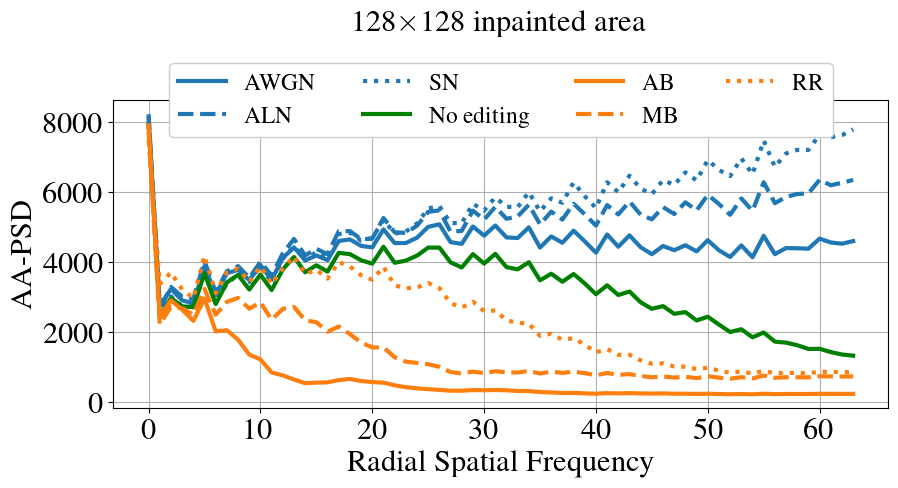

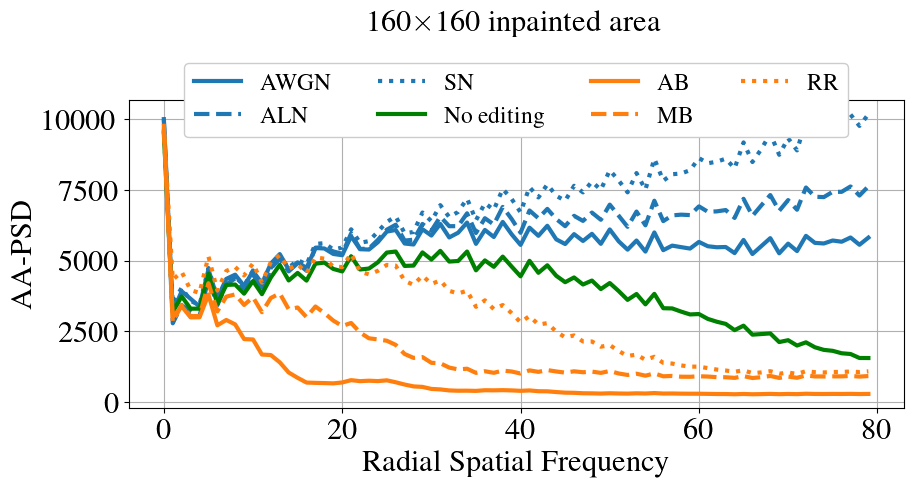

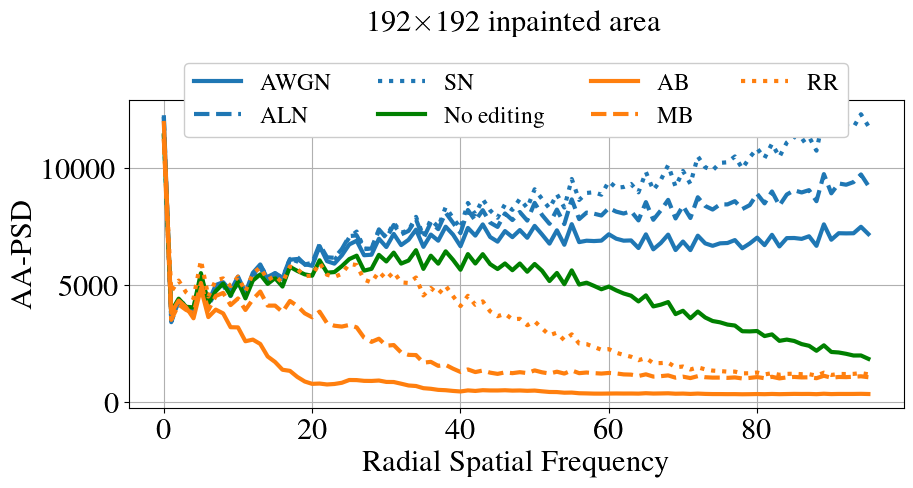

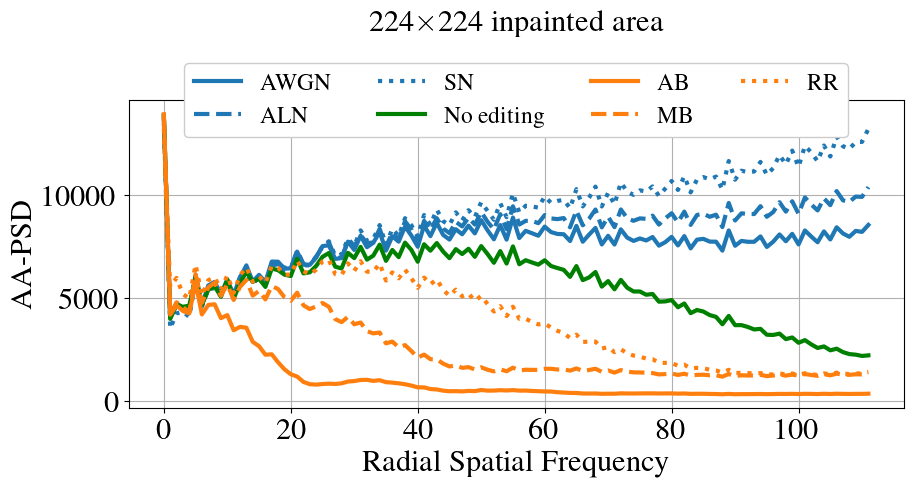

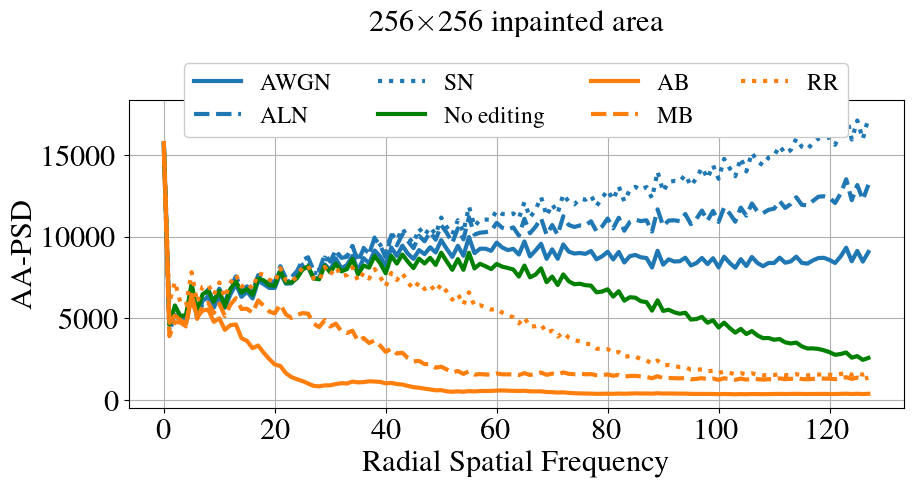

In [30]:
# Plot parameters
fsize = 22
lw = 3

# Operation parameters
ops = ['AdditiveWhiteGaussianNoise',
       'AdditiveLaplacianNoise',
       'AverageBlur', 'MedianBlur',
       'NoEditing', 'SpeckleNoise', 'RotationResize']
labels = {'AdditiveWhiteGaussianNoise': 'AWGN',
          'AdditiveLaplacianNoise': 'ALN',
          'AverageBlur': 'AB', 'MedianBlur': 'MB',
          'NoEditing': 'No editing', 'SpeckleNoise': 'SN', 
          'RotationResize': 'RR'}
nb_ops = ['AdditiveWhiteGaussianNoise', 'AdditiveLaplacianNoise', 'SpeckleNoise']
ib_ops = ['AverageBlur', 'MedianBlur', 'RotationResize']
group_linestyles = {'nb': ['solid', 'dashed', 'dotted'], 'ib': ['solid', 'dashed', 'dotted', 'dashdot']}

# Actual plotting
save_figure = False
save_path = './figures'
for size in sorted(rps_mean.keys()): 
    fig, axs = plt.subplots(1, 1, figsize=(10, 4))
    for idx, op in enumerate(nb_ops):
        axs.plot(rps_mean[size][op], label=f'{labels[op]}', 
                 color='#1F77B4', linestyle=group_linestyles['nb'][idx], linewidth=lw)
    axs.plot(rps_mean[size]['NoEditing'], color='green', linestyle='solid', label='No editing', linewidth=lw)
    for idx, op in enumerate(ib_ops):
        axs.plot(rps_mean[size][op], label=f'{labels[op]}', 
                     color='#FF7F0E', linestyle=group_linestyles['ib'][idx], linewidth=lw)
    axs.set_ylabel("AA-PSD",fontsize=fsize)
    axs.set_xlabel("Radial Spatial Frequency", fontsize=fsize)
    axs.tick_params(axis='both', labelsize=fsize)
    axs.legend(fontsize=fsize-5, ncol=4, loc='center', bbox_to_anchor=[0.5, 1], framealpha=1)
    axs.grid()
    if not save_figure:
        axs.set_title(fr'{size}$\times${size} inpainted area', fontsize=fsize, y=1.2)
    else:
        plt.savefig(os.path.join(save_path, f'aa_psd_{size}_all_ops_short_short.pdf'), dpi=300, bbox_inches='tight')
    plt.show()

## What happens if instead we try to clusterize the fingerprints?
Will we see a difference in Euclidean distance given by the different appearance?

In [31]:
from sklearn.manifold import MDS
from tqdm.notebook import tqdm

In [32]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

### Let's divide in low-pass and high-pass operations

In [39]:
# --- Let's cycle over them
ops = ['AdditiveWhiteGaussianNoise',
       'AdditiveLaplacianNoise',
       'AverageBlur', 'MedianBlur',
       'NoEditing', 'SpeckleNoise', 'RotationResize']
nb_ops = ['AdditiveWhiteGaussianNoise', 'AdditiveLaplacianNoise', 'SpeckleNoise']
ib_ops = ['AverageBlur', 'MedianBlur', 'RotationResize']

fps_dict = dict()
fp_root_dir = '..'
for sa in tqdm(df['splice_size'].unique(), desc='Computing MDS over different spliced area sizes'):
    fps_dict[sa] = dict()
    # Add noise-based editing
    for op in nb_ops:
        sel_df = df.loc[op]
        sel_df = sel_df.loc[sel_df['splice_size']==sa]
        sp_areas = []
        for i, row in sel_df.iterrows():
            fp_path, mask_path = row['fp_path'], row['mask_paths']

            # Load the fingerprint and mask
            fp = np.load(os.path.join(fp_root_dir, fp_path))
            mask = cv2.imread(os.path.join(img_dir, mask_path), cv2.IMREAD_UNCHANGED)

            # Load the spliced area
            sp_area = fp[mask.astype(np.bool)].reshape([sa, sa])

            # Add it to to the list of fingerprints
            sp_areas.append(np.expand_dims(sp_area.copy(), axis=0))
            
        # Concatenate them together
        fps_dict[sa][op] = np.concatenate(sp_areas, axis=0)
    
    # Add interpolation-based editing
    for op in ib_ops:
        sel_df = df.loc[op]
        sel_df = sel_df.loc[sel_df['splice_size']==sa]
        sp_areas = []
        for i, row in sel_df.iterrows():
            fp_path, mask_path = row['fp_path'], row['mask_paths']

            # Load the fingerprint and mask
            fp = np.load(os.path.join(fp_root_dir, fp_path))
            mask = cv2.imread(os.path.join(img_dir, mask_path), cv2.IMREAD_UNCHANGED)

            # Load the spliced area
            sp_area = fp[mask.astype(np.bool)].reshape([sa, sa])

            # Add it to to the list of fingerprints
            sp_areas.append(np.expand_dims(sp_area.copy(), axis=0))
            
        # Concatenate them together
        fps_dict[sa][op] = np.concatenate(sp_areas, axis=0)
    
    # Add no-editing
    sel_df = df.loc['NoEditing']
    sel_df = sel_df.loc[sel_df['splice_size']==sa]
    sp_areas = []
    for i, row in sel_df.iterrows():
        fp_path, mask_path = row['fp_path'], row['mask_paths']

        # Load the fingerprint and mask
        fp = np.load(os.path.join(fp_root_dir, fp_path))
        mask = cv2.imread(os.path.join(img_dir, mask_path), cv2.IMREAD_UNCHANGED)

        # Load the spliced area
        sp_area = fp[mask.astype(np.bool)].reshape([sa, sa])

        # Add it to to the list of fingerprints
        sp_areas.append(np.expand_dims(sp_area.copy(), axis=0))

    # Concatenate them together
    fps_dict[sa]['No editing'] = np.concatenate(sp_areas, axis=0)


Computing MDS over different spliced area sizes:   0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipykernel_578527/3172578751.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sp_area = fp[mask.astype(np.bool)].reshape([sa, sa])
/tmp/ipykernel_578527/3172578751.py:47: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sp_area = fp[mask.astype(np.bool)].reshape([sa, sa])
/tmp/ipykernel_578527/3172578751.py:67: DeprecationWarning: `np.bool` is

Let's try with a smaller figure

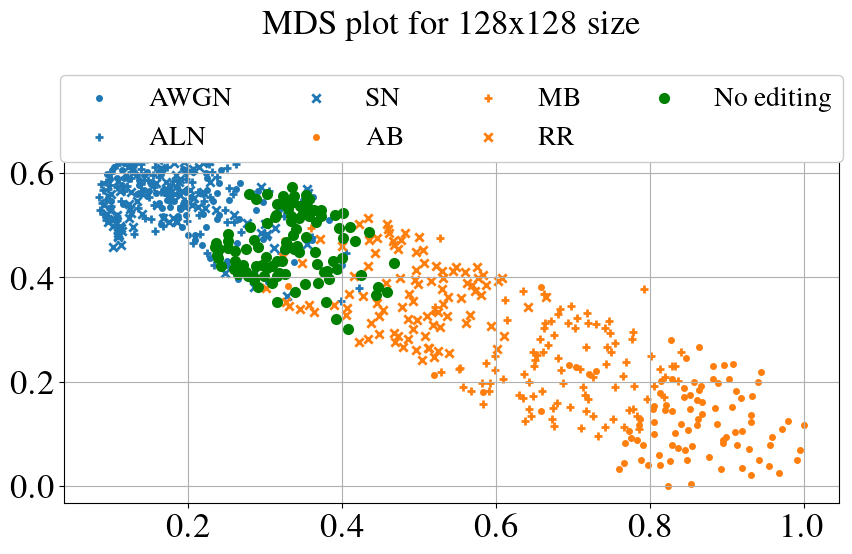

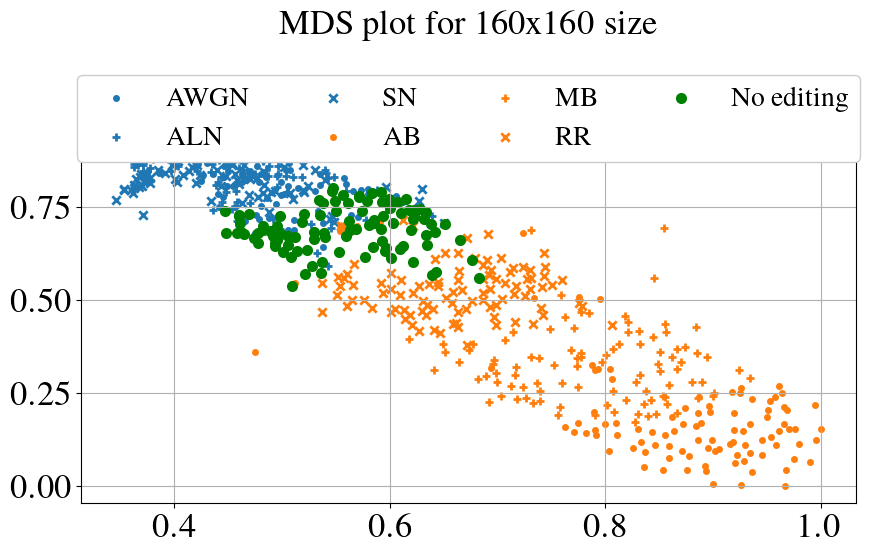

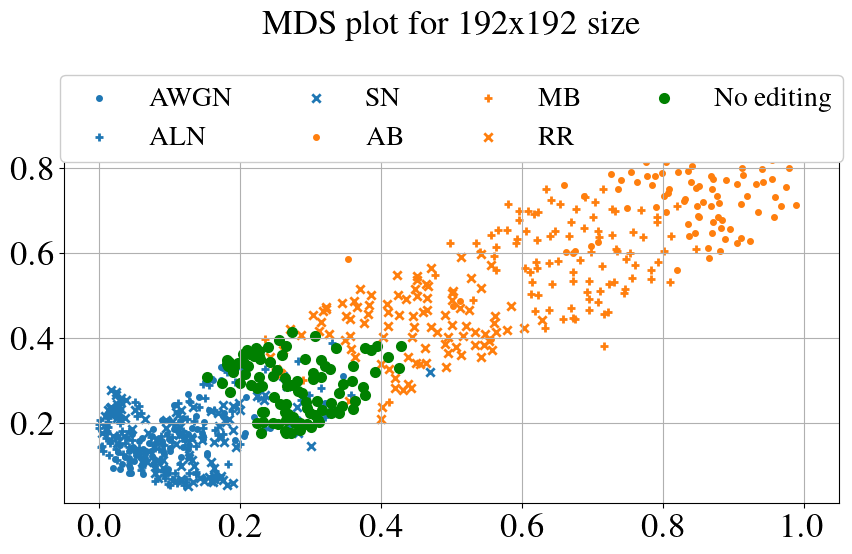

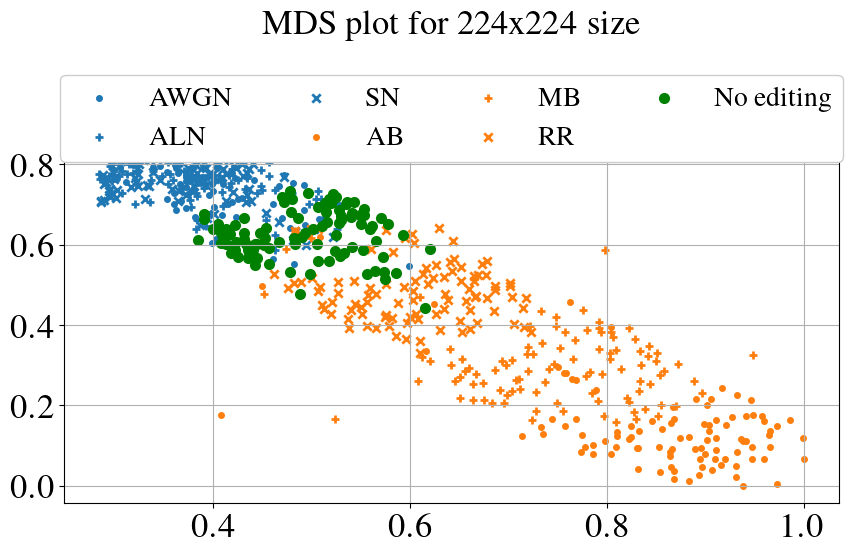

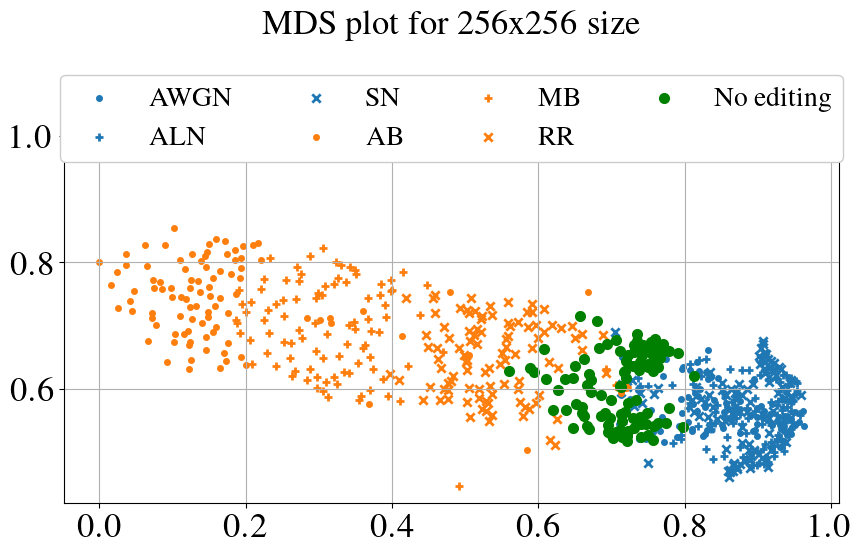

In [45]:
# Plot parameters
ops = ['AdditiveWhiteGaussianNoise',
       'AdditiveLaplacianNoise',
       'AverageBlur', 'MedianBlur',
       'NoEditing', 'SpeckleNoise', 'RotationResize']
labels = {'AdditiveWhiteGaussianNoise': 'AWGN',
          'AdditiveLaplacianNoise': 'ALN',
          'AverageBlur': 'AB', 'MedianBlur': 'MB',
          'No editing': 'No editing', 'SpeckleNoise': 'SN', 
          'RotationResize': 'RR'}
nb_ops = ['AdditiveWhiteGaussianNoise', 'AdditiveLaplacianNoise', 'SpeckleNoise']
ib_ops = ['AverageBlur', 'MedianBlur', 'RotationResize']
group_markers = {'nb': ['.', '+', 'x'], 'ib': ['.', '+', 'x', '^']}
cmap = get_cmap(len(ops), name='tab10')
fsize = 25

# Plotting
save_figure = False
for size in sorted(fps_dict.keys()):
    fig, axs = plt.subplots(1, 1, figsize=(10, 5))
    embs = MDS(n_components=2, random_state=42).fit_transform(np.concatenate([fps_dict[size][op] for op in nb_ops+ib_ops+['No editing']]).reshape(-1, size*size))
    embs = (embs-embs.min())/(embs.max()-embs.min())
    pr_len = 0
    
    # Scatter noise-based editing
    for idx, op in enumerate(nb_ops):
        axs.scatter(embs[pr_len:pr_len+fps_dict[size][op].shape[0], 0], embs[pr_len:pr_len+fps_dict[size][op].shape[0], 1], 
                    label=labels[op], color='#1F77B4', marker=group_markers['nb'][idx], linewidth=2)
        pr_len += fps_dict[size][op].shape[0]
        
    # Scatter interpolation-based editing
    for idx, op in enumerate(ib_ops):
        axs.scatter(embs[pr_len:pr_len+fps_dict[size][op].shape[0], 0], embs[pr_len:pr_len+fps_dict[size][op].shape[0], 1], 
                    label=labels[op], color='#FF7F0E', marker=group_markers['ib'][idx], linewidth=2)
        pr_len += fps_dict[size][op].shape[0]
    
    # Scatter no-editing
    op = 'No editing'
    axs.scatter(embs[pr_len:pr_len+fps_dict[size][op].shape[0], 0], embs[pr_len:pr_len+fps_dict[size][op].shape[0], 1], 
                    label=labels[op], color='green', linewidth=2)
    pr_len += fps_dict[size][op].shape[0]
    
    axs.tick_params(axis='both', labelsize=fsize)
    axs.legend(fontsize=fsize-5, ncol=4, loc='center', bbox_to_anchor=[0.5, 1], framealpha=1)
    axs.grid()
    if not save_figure:
        axs.set_title(f'MDS plot for {size}x{size} size', fontsize=fsize, y=1.2)
    else:
        plt.savefig(os.path.join(save_path, f'mds_{size}_all_ops_short.pdf'), dpi=300, bbox_inches='tight')
    plt.show()
    


## Last experiment
Can we get a more compact metric about the nature of the fingerprints?  
Let's use the AUC computed directly binarizing the fingerprint. For noise-based attacks, it will have positive values (since the area will appear bright), while for interpolation-based attacks, it will have negative values (since the area will appear dark).

In [46]:
results_df = df.copy()
results_df['AUC'] = 0.0
results_df

filenames  \
Operation              Img_idx                                                
AdditiveLaplacianNoise 0        AdditiveLaplacianNoise/img_14_size_192.tiff   
                       1        AdditiveLaplacianNoise/img_18_size_192.tiff   
                       2        AdditiveLaplacianNoise/img_18_size_256.tiff   
                       3        AdditiveLaplacianNoise/img_22_size_192.tiff   
                       4        AdditiveLaplacianNoise/img_26_size_128.tiff   
...                                                                     ...   
NoEditing              495                   NoEditing/img_35_size_256.tiff   
                       496                   NoEditing/img_49_size_192.tiff   
                       497                   NoEditing/img_14_size_160.tiff   
                       498                   NoEditing/img_55_size_256.tiff   
                       499                   NoEditing/img_78_size_128.tiff   

                                                                     mask_paths  \
Operation              Img_idx                                                    
AdditiveLaplacianNoise 0        AdditiveLaplacianNoise/mask_img_14_size_192.png   
                       1        AdditiveLaplacianNoise/mask_img_18_size_192.png   
                       2        AdditiveLaplacianNoise/mask_img_18_size_256.png   
                       3        AdditiveLaplacianNoise/mask_img_22_size_192.png   
                       4        AdditiveLaplacianNoise/mask_img_26_size_128.png   
...                                                                         ...   
NoEditing              495                   NoEditing/mask_img_35_size_256.png   
                       496                   NoEditing/mask_img_49_size_192.png   
                       497                   NoEditing/mask_img_14_size_160.png   
                       498                   NoEditing/mask_img_55_size_256.png   
                       499                   NoEditing/mask_img_78_size_128.png   

                                splice_size  \
Operation              Img_idx                
AdditiveLaplacianNoise 0                192   
                       1                192   
                       2                256   
                       3                192   
                       4                128   
...                                     ...   
NoEditing              495              256   
                       496              192   
                       497              160   
                       498              256   
                       499              128   

                                                                          fp_path  \
Operation              Img_idx                                                      
AdditiveLaplacianNoise 0        test_results/asae/AdditiveLaplacianNoise/finge...   
                       1        test_results/asae/AdditiveLaplacianNoise/finge...   
                       2        test_results/asae/AdditiveLaplacianNoise/finge...   
                       3        test_results/asae/AdditiveLaplacianNoise/finge...   
                       4        test_results/asae/AdditiveLaplacianNoise/finge...   
...                                                                           ...   
NoEditing              495      test_results/asae/NoEditing/fingerprints/fp_im...   
                       496      test_results/asae/NoEditing/fingerprints/fp_im...   
                       497      test_results/asae/NoEditing/fingerprints/fp_im...   
                       498      test_results/asae/NoEditing/fingerprints/fp_im...   
                       499      test_results/asae/NoEditing/fingerprints/fp_im...   

                                AUC  
Operation              Img_idx       
AdditiveLaplacianNoise 0        0.0  
                       1        0.0  
                       2        0.0  
                       3        0.0  
            

In [47]:
from typing import Tuple

def compute_roc_and_auc(row_idx: pd.Index) -> pd.Series:
    # Unpack
    row = results_df.loc[row_idx]
    
    # Pick the values
    fp_path, mask_path = row['fp_path'], row['mask_paths']

    # Load the fingerprint and mask
    fp = np.load(os.path.join(fp_root_dir, fp_path))
    mask = cv2.imread(os.path.join(img_dir, mask_path), cv2.IMREAD_UNCHANGED)
    
    # Compute the ROC curve and AUC
    fpr, tpr, _ = roc_curve(mask.astype(bool).flatten(), fp.flatten())
    results_df.loc[row_idx, 'AUC'] = auc(fpr, tpr)
    
    return None

In [48]:
from sklearn.metrics import roc_curve, auc
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor

num_workers = 16
with ThreadPoolExecutor(num_workers) as p:
    _ = list(tqdm(p.map(compute_roc_and_auc, results_df.index.tolist())))

results_df['AUC']

0it [00:00, ?it/s]

Operation               Img_idx
AdditiveLaplacianNoise  0          0.914695
                        1          0.682709
                        2          0.972699
                        3          0.980150
                        4          0.939501
                                     ...   
NoEditing               495        0.443254
                        496        0.464879
                        497        0.558796
                        498        0.515216
                        499        0.484013
Name: AUC, Length: 3500, dtype: float64

### Let's plot the distribution of scores separating editing operation based on their nature

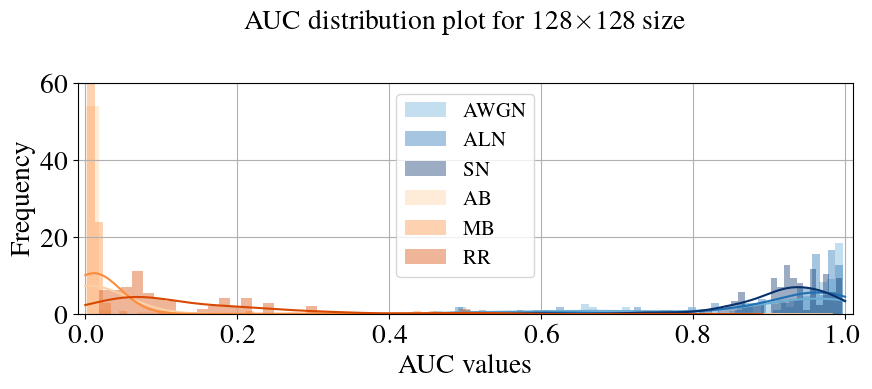

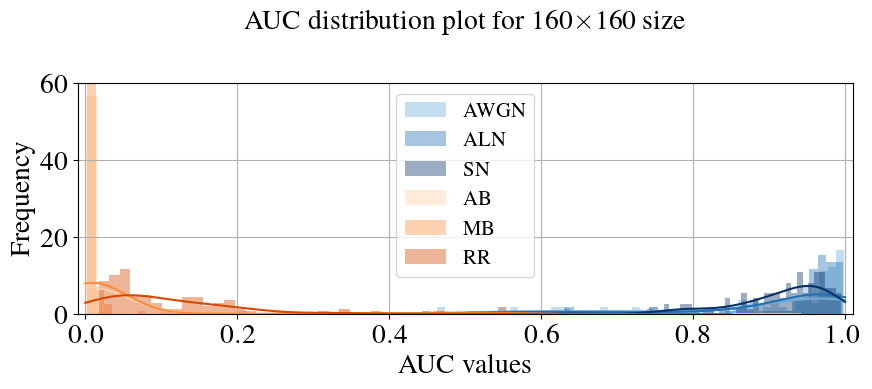

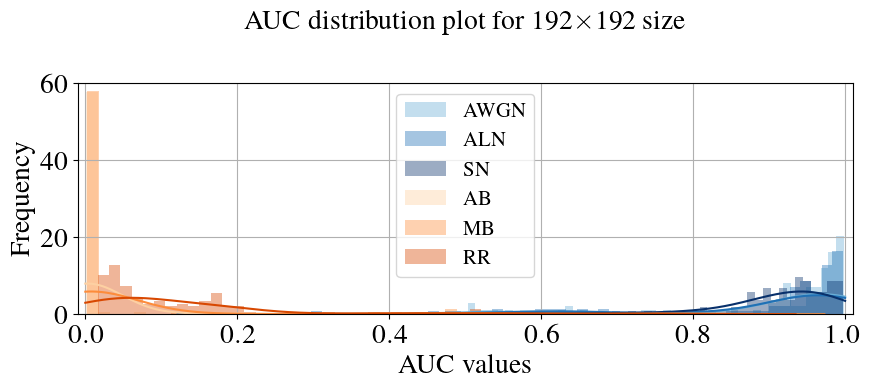

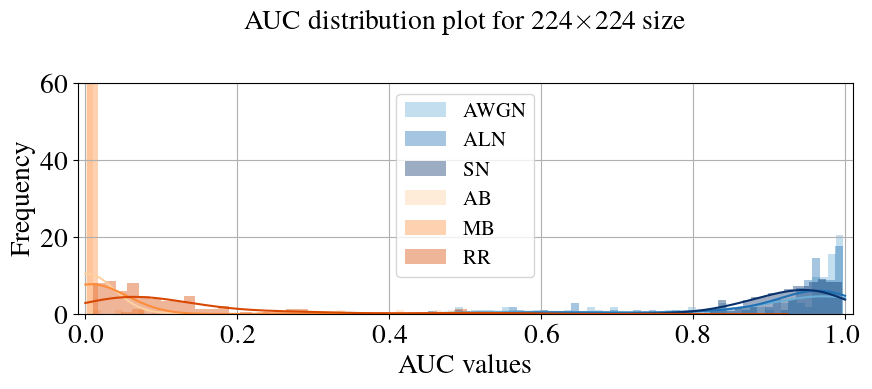

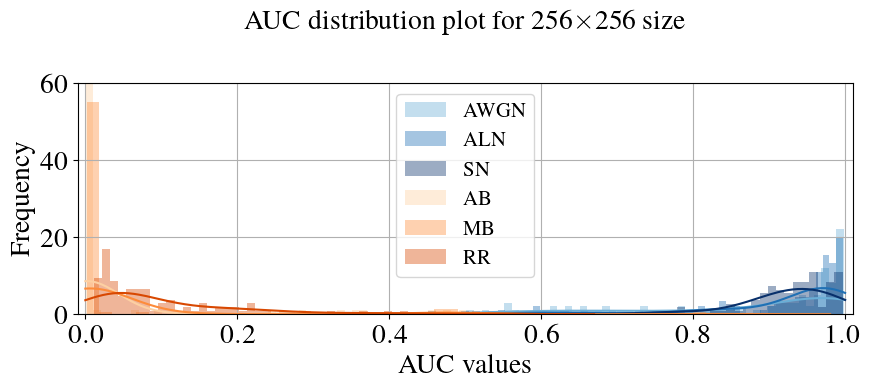

In [52]:
from matplotlib import rc
import numpy as np
import seaborn
rc('font',**{'family':'Times'})
rc('text', usetex=True)

# Plot parameters
ops = ['AdditiveWhiteGaussianNoise',
       'AdditiveLaplacianNoise',
       'AverageBlur', 'MedianBlur',
       'NoEditing', 'SpeckleNoise', 'RotationResize']
labels = {'AdditiveWhiteGaussianNoise': 'AWGN',
          'AdditiveLaplacianNoise': 'ALN',
          'AverageBlur': 'AB', 'MedianBlur': 'MB',
          'No editing': 'No editing', 'SpeckleNoise': 'SN', 
          'RotationResize': 'RR'}
nb_ops = ['AdditiveWhiteGaussianNoise', 'AdditiveLaplacianNoise', 'SpeckleNoise']
ib_ops = ['AverageBlur', 'MedianBlur', 'RotationResize']
colors = {'nb': np.linspace(0.5, 1, len(nb_ops)), 'ib': np.linspace(0.25, 0.75, len(ib_ops))}
fsize = 20

# Plotting
save_figure = False
for size in sorted(results_df['splice_size'].unique()):
    splicing_df = results_df.loc[results_df['splice_size']==size]
    fig, axs = plt.subplots(1, 1, figsize=(10, 3))

    # Distribution of noise-based editing AUC values
    for idx, op in enumerate(nb_ops):
        op_df = splicing_df.loc[op]
        counts, bins = np.histogram(op_df['AUC'], bins=50)
        seaborn.distplot(op_df['AUC'], bins=bins, 
                         kde=True, label=labels[op], 
                         color=plt.cm.Blues(colors['nb'][idx]),
                         ax=axs, kde_kws={'clip': [0, 1]})

    # Distribution of interpolation-based editing AUC values
    for idx, op in enumerate(ib_ops):
        op_df = splicing_df.loc[op]
        counts, bins = np.histogram(op_df['AUC'], bins=50)
        seaborn.distplot(op_df['AUC'], 
                         bins=bins, kde=True, label=labels[op], 
                         color=plt.cm.Oranges(colors['ib'][idx]),
                         ax=axs, kde_kws={'clip': [0, 1]})

    axs.tick_params(axis='both', labelsize=fsize)
    axs.set_xlabel('AUC values', fontsize=fsize)
    axs.set_ylabel('Frequency', fontsize=fsize)
    axs.set_xlim([-0.01, 1.01])
    axs.set_ylim([-0.0, 60])
    axs.legend(fontsize=fsize-5, loc='upper center')
    axs.grid()
    if not save_figure:
        axs.set_title(fr'AUC distribution plot for {size}$\times${size} size', fontsize=fsize, y=1.2)
    else:
        plt.savefig(os.path.join(save_path, f'auc_distplot_{size}.pdf'), dpi=300, bbox_inches='tight')
    plt.show()
